# Teacher-Student Training Script 

(In progress)

In [41]:
#!/usr/bin/env python3
"""Visualization script for Go1 with height scanner."""
import os
import subprocess
# Tell XLA to use Triton GEMM
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
os.environ['MUJOCO_GL'] = 'egl'

import jax
import jax.numpy as jp
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import losses as ppo_losses

import mujoco
from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import locomotion_params
from custom_env import Joystick, default_config

from datetime import datetime
import mediapy as media
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import functools
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPyimage, display, HTML, clear_output

from utils import render_video_during_training, evaluate_policy

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True   # Show visual geoms
scene_option.geomgroup[3] = False  # Hide collision geoms
scene_option.geomgroup[5] = True   # Show sites (including height scanner visualization)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # Show contact points
scene_option.flags[mujoco.mjtVisFlag.mjVIS_RANGEFINDER] = True
print("Creating Visualization...")

xml_path = 'custom_env.xml' # 'custom_env_debug_wall.xml'
env = Joystick(xml_path=xml_path, config=default_config())

# JIT compile the functions for speed
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_terrain_height = jax.jit(env._get_torso_terrain_height)

seed = 1234
num_envs = ()
key = jax.random.PRNGKey(seed)
key, key_env, eval_key, key_policy, key_value = jax.random.split(key, 5)
key_envs = jax.random.split(key_env, num_envs)
env_state = jit_reset(key_envs)

Creating Visualization...


# Teacher Policy

- pretrained inside train.ipynb
- we want to load the parameters

- Inputs: privileged_state with heightmap
- Output: action

### Load parameters for pre-trained teacher


In [42]:
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import losses as ppo_losses
from brax.training.acme import running_statistics


# Needs to match training
obs_shape = (96,)
action_size = env.action_size

# Observation normalisation
loaded_params = np.load("params.npy", allow_pickle=True)
normalizer_params = loaded_params[0]  
normalize = running_statistics.normalize

# Setup
ppo_params = locomotion_params.brax_ppo_config('Go1JoystickRoughTerrain')
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
    network_factory = functools.partial(
        ppo_networks.make_ppo_networks,
        **ppo_params.network_factory
    )

ppo_network = network_factory(
    obs_shape, action_size, preprocess_observations_fn=normalize
)

init_params = ppo_losses.PPONetworkParams(
    policy=ppo_network.policy_network.init(key_policy),
    value=ppo_network.value_network.init(key_value),
)

# Create policy function
make_policy = ppo_networks.make_inference_fn(ppo_network)

params = np.load("params.npy", allow_pickle=True)

jit_inference_fn = jax.jit(make_policy(params, deterministic=True))

# Training

- Teacher is run for one episode at a time with privileged observations
- Non-priveleged observations are saved as student input
- action distribution (logits) are saved as student targets
- RNN is trained with data from episode


In [43]:
from custom_ppo_train import _maybe_wrap_env

seed = 42

episodes = 1000
envs_per_episode = 1
episode_length = 512  
action_repeat = 1

learning_rate = 3e-4  
batch_size = 128      
batches = episode_length // batch_size 

print(f"Training config: {episodes} episodes, {episode_length} steps per episode")
print(f"Batch config: {batch_size} batch size, {batches} batches per episode")

teacher_visualisation = False

Training config: 1000 episodes, 512 steps per episode
Batch config: 128 batch size, 4 batches per episode


# Student Policy

Experiment 1: training with a newly initialized LSTM for a Recurrent Neural Network

In [44]:
# Policy Definition
import jax.numpy as jnp
import jax
import flax.linen as nn
import optax

class StudentPolicy(nn.Module):
    """LSTM-based student policy that mimics teacher's action distribution"""
    action_size: int = 12
    hidden_size: int = 64
    
    def setup(self):
        self.lstm_cell = nn.LSTMCell(features=self.hidden_size)
        self.dense = nn.Dense(features=2 * self.action_size)
    
    def __call__(self, x, carry=None):
        # x shape: (batch_size, obs_dim)
        batch_size = x.shape[0]
        
        # Initialize carry state if not provided
        if carry is None:
            carry = self.lstm_cell.initialize_carry(jax.random.PRNGKey(0), (batch_size,))
        
        # Process single step
        new_carry, lstm_output = self.lstm_cell(carry, x)
        
        # Dense layer to match teacher's logits output (24 = 12 means + 12 log_stds)
        logits = self.dense(lstm_output)
        
        return logits, new_carry
    
    def initialize_carry(self, batch_size, key=None):
        """Helper method to initialize carry state"""
        if key is None:
            key = jax.random.PRNGKey(0)
        return self.lstm_cell.initialize_carry(key, (batch_size,))

# Initialize student network
student_obs_dim = 52

# Create student network
student_net = StudentPolicy(action_size = action_size)

# Initialize with dummy data
dummy_input = jnp.ones((batch_size, student_obs_dim))
key_student = jax.random.PRNGKey(42)
student_params = student_net.init(key_student, dummy_input)

print(f"Student network initialized!")
print(f"Input shape: {dummy_input.shape}")
print(f"Expected output shape: (batch_size, 24) for logits")

# Test student network
test_output, test_carry = student_net.apply(student_params, dummy_input)
print(f"Test output shape: {test_output.shape}")
print(f"Test carry shape: {[c.shape for c in test_carry]}")

Student network initialized!
Input shape: (128, 52)
Expected output shape: (batch_size, 24) for logits
Test output shape: (128, 24)
Test carry shape: [(128, 64), (128, 64)]


# Helper Functions for Teacher-Student Training
Define the functions needed to extract logits from the teacher network.

In [46]:
# Function to get logits from teacher network
@jax.jit
def get_teacher_logits(params, observations):
    param_subset = (params[0], params[1])  # normalizer and policy params
    return ppo_network.policy_network.apply(*param_subset, observations)

# Helper function to initialize carry state
def init_carry_state(batch_size, hidden_size=64, key=None):
    """Initialize LSTM carry state manually"""
    if key is None:
        key = jax.random.PRNGKey(0)
    # LSTM carry state is (hidden_state, cell_state)
    hidden_state = jnp.zeros((batch_size, hidden_size))
    cell_state = jnp.zeros((batch_size, hidden_size))
    return (hidden_state, cell_state)

# Training setup
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(student_params)

# Training function - optimized for stability
def train_step_sequential(params, opt_state, episode_inputs, episode_targets):
    """Train on full episode sequence to learn temporal dependencies"""
    
    def single_step_loss(carry_and_params, step_data):
        """Process a single step and return loss + updated carry"""
        carry, params = carry_and_params
        step_input, step_target = step_data
        
        # Add batch dimension if needed
        if step_input.ndim == 1:
            step_input = step_input[None, :]
        if step_target.ndim == 1:
            step_target = step_target[None, :]
            
        prediction, new_carry = student_net.apply(params, step_input, carry)
        loss = jnp.mean((prediction - step_target) ** 2)
        return (new_carry, params), loss
    
    def loss_fn(params):
        # Initialize carry state for the episode
        carry = init_carry_state(1, hidden_size=64)
        
        # Use scan for efficient sequential processing
        (final_carry, _), losses = jax.lax.scan(
            single_step_loss,
            (carry, params),
            (episode_inputs, episode_targets)
        )
        
        return jnp.mean(losses)
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# JIT compile the training function
jit_train_step_sequential = jax.jit(train_step_sequential)

## Training Loop



In [47]:
from mujoco_playground._src.gait import draw_joystick_command
env_cfg = default_config()
env_cfg.pert_config.enable = True
env_cfg.pert_config.velocity_kick = [0.0, 0.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.8, 2*jp.pi]


# Loop over episodes
training_losses = []
test_losses = []
for episode in range(episodes):
    print(f"\n Episode {episode + 1}/{episodes} ")
    
    key = jax.random.PRNGKey(seed + episode)
    key, key_env, eval_key, key_policy, key_value = jax.random.split(key, 5)

    wrapper_env = _maybe_wrap_env(
        env,
        wrap_env=True,
        num_envs=envs_per_episode,
        episode_length=episode_length,
        action_repeat=action_repeat,
        key_env=key_env,
    )

    # Reset environment 
    reset_fn = jax.jit(env.reset)
    key_envs = jax.random.split(key_env, num_envs)
    env_state = reset_fn(key_envs)

    rng = jax.random.PRNGKey(episode)
    #raw_command = jax.random.uniform(rng, shape=(3), minval=0.0, maxval=1.0)
    raw_command = jp.array([0.5, 0.0, 0.0]) 

    command = jp.array([
        raw_command[0] * env_cfg.command_config.a[0], 
        raw_command[1] * env_cfg.command_config.a[1],
        raw_command[2] * env_cfg.command_config.a[2] 
    ])
    state = jit_reset(rng)
    state.info["command"] = command

    # Visualisation storing
    rollout = []
    modify_scene_fns = []

    # Training data storing
    student_inputs = []
    student_targets = []
    
    for step in range(episode_length):
        # Get teacher action and logits
        act_rng, rng = jax.random.split(rng)
        ctrl, actions = jit_inference_fn(state.obs, act_rng)
        
        # Get teacher logits (distribution parameters)
        param_subset = (params[0], params[1])
        logits = ppo_network.policy_network.apply(*param_subset, state.obs)
        
        # Store data for student training
        student_inputs.append(state.obs['state'][:student_obs_dim])  # Non-privileged observations
        student_targets.append(logits)  # Teacher's action distribution logits
        
        # Step environment
        state = jit_step(state, ctrl)
        state.info["command"] = command
        
        # Visualization data
        rollout.append(state)
        xyz = np.array(state.data.xpos[env._torso_body_id])
        xyz += np.array([0, 0, 0.2])
        x_axis = state.data.xmat[env._torso_body_id, 0]
        yaw = -np.arctan2(x_axis[1], x_axis[0])
        modify_scene_fns.append(
            functools.partial(
                draw_joystick_command,
                cmd=state.info["command"],
                xyz=xyz,
                theta=yaw,
                scl=abs(state.info["command"][0]) / env_cfg.command_config.a[0],
            )
        )

    # Prepare training data
    student_inputs_array = jnp.array(student_inputs)  # (256, 52)
    student_targets_array = jnp.array(student_targets)  # (256, 24)
            
    # Train student using sequential training (maintains carry across episode)
    student_params, opt_state, loss = jit_train_step_sequential(
        student_params, opt_state, student_inputs_array, student_targets_array
    )
    training_losses.append(float(loss))


    # Optional visualization
    if teacher_visualisation: 
        render_every = 2
        fps = 1.0 / env.dt / render_every
        traj = rollout[::render_every]
        mod_fns = modify_scene_fns[::render_every]

        scene_option = mujoco.MjvOption()
        scene_option.geomgroup[2] = True
        scene_option.geomgroup[3] = False
        scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
        scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
        scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

        frames = env.render(
            traj,
            camera="track",
            scene_option=scene_option,
            width=640,
            height=480,
            modify_scene_fns=mod_fns,
        )   
        media.show_video(frames, fps=fps)




 Episode 1/1000 

 Episode 2/1000 

 Episode 2/1000 

 Episode 3/1000 

 Episode 3/1000 

 Episode 4/1000 

 Episode 4/1000 

 Episode 5/1000 

 Episode 5/1000 

 Episode 6/1000 

 Episode 6/1000 

 Episode 7/1000 

 Episode 7/1000 

 Episode 8/1000 

 Episode 8/1000 

 Episode 9/1000 

 Episode 9/1000 

 Episode 10/1000 

 Episode 10/1000 

 Episode 11/1000 

 Episode 11/1000 

 Episode 12/1000 

 Episode 12/1000 

 Episode 13/1000 

 Episode 13/1000 

 Episode 14/1000 

 Episode 14/1000 

 Episode 15/1000 

 Episode 15/1000 

 Episode 16/1000 

 Episode 16/1000 

 Episode 17/1000 

 Episode 17/1000 

 Episode 18/1000 

 Episode 18/1000 

 Episode 19/1000 

 Episode 19/1000 

 Episode 20/1000 

 Episode 20/1000 

 Episode 21/1000 

 Episode 21/1000 

 Episode 22/1000 

 Episode 22/1000 

 Episode 23/1000 

 Episode 23/1000 

 Episode 24/1000 

 Episode 24/1000 

 Episode 25/1000 

 Episode 25/1000 

 Episode 26/1000 

 Episode 26/1000 

 Episode 27/1000 

 Episode 27/1000 

 Episode 

### Plot training metrics


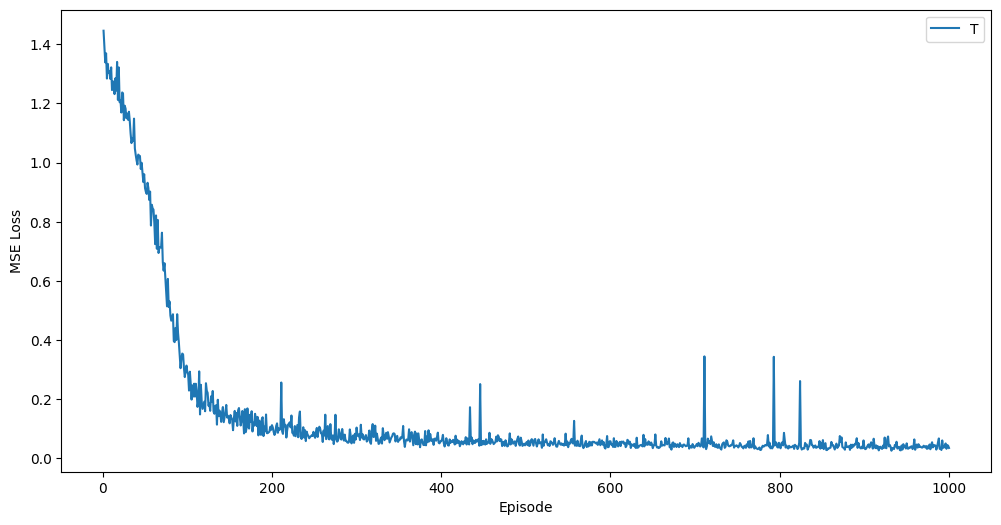

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(1, len(training_losses) + 1), training_losses)
plt.xlabel("Episode")
plt.ylabel("MSE Loss")
plt.legend(("Training Loss"))
plt.show()

### (OPTIONAL): Load Trained RNN


In [ ]:
import pickle
# Load student RNN parameters
with open('student_params.pkl', 'rb') as f:
    student_params = pickle.load(f)
print("Student RNN loaded from student_params.pkl")

## Evaluate Student Polcicy

### Evaluation Environment Config


In [49]:
# Env config
student_env_cfg = default_config()
student_env_cfg.pert_config.enable = True
student_env_cfg.pert_config.velocity_kick = [0.0, 0.0]
student_env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
student_env_cfg.command_config.a = [1.5, 0.8, 2*jp.pi] # Max command values

seed = 42

num_episodes = 5
episode_length = 500


In [ ]:
# Student eval
from mujoco_playground._src.gait import draw_joystick_command

for episode in range(num_episodes):
    key = jax.random.PRNGKey(episode + seed)
    key, key_env, eval_key, key_policy, key_value = jax.random.split(key, 5)

    wrapper_env = _maybe_wrap_env(
    env,
    wrap_env = True,
    num_envs = 1,
    episode_length = episode_length,
    action_repeat = 1,
    key_env = key_env,
    )

    # Reset environment 
    reset_fn = jax.jit(env.reset)
    key_envs = jax.random.split(key_env, num_envs)
    env_state = reset_fn(key_envs)

    
    # Set commands 
    rng = jax.random.PRNGKey(episode)
    #raw_command = jax.random.uniform(rng, shape=(3), minval=0.0, maxval=1.0)
    raw_command = jp.array([0.5, 0.0, 0.0])  # Hard coded for testing

    command = jp.array([
        raw_command[0] * student_env_cfg.command_config.a[0], 
        raw_command[1] * student_env_cfg.command_config.a[1],
        raw_command[2] * student_env_cfg.command_config.a[2] 
    ])
    state = jit_reset(rng)
    state.info["command"] = command

    # Visualisation storing
    rollout = []
    modify_scene_fns = []

    # Initialize student carry state (this persists across steps)
    student_carry = init_carry_state(1, hidden_size=64, key=jax.random.PRNGKey(episode))

    for step in range(episode_length):
        # feed non-priveleged observations to network
        student_obs = state.obs['state'] 

        # Get student logits from RNN with persistent carry state
        student_obs_batch = student_obs[:student_obs_dim].reshape(1, -1)
        logits, student_carry = student_net.apply(student_params, student_obs_batch, student_carry)
        logits = logits.squeeze(0) 

        # Convert logits to action
        parametric_action_distribution = ppo_network.parametric_action_distribution
        raw_action = parametric_action_distribution.sample_no_postprocessing(logits, rng)
        ctrl = parametric_action_distribution.postprocess(raw_action)

        # Take step
        state = jit_step(state, ctrl)
        state.info["command"] = command

        # Visualization magic
        rollout.append(state)
        xyz = np.array(state.data.xpos[env._torso_body_id])
        xyz += np.array([0, 0, 0.2])
        x_axis = state.data.xmat[env._torso_body_id, 0]
        yaw = -np.arctan2(x_axis[1], x_axis[0])
        modify_scene_fns.append(
            functools.partial(
                draw_joystick_command,
                cmd=state.info["command"],
                xyz=xyz,
                theta=yaw,
                scl=abs(state.info["command"][0]) / student_env_cfg.command_config.a[0],
            )
        )

    # Display visualisation magic
    render_every = 2
    fps = 1.0 / env.dt / render_every
    traj = rollout[::render_every]
    mod_fns = modify_scene_fns[::render_every]

    scene_option = mujoco.MjvOption()
    scene_option.geomgroup[2] = True
    scene_option.geomgroup[3] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

    frames = env.render(
        traj,
        camera="track",
        scene_option=scene_option,
        width=640,
        height=480,
        modify_scene_fns=mod_fns,
    )   
    media.show_video(frames, fps=fps)

100%|██████████| 250/250 [00:02<00:00, 87.39it/s]



100%|██████████| 250/250 [00:02<00:00, 85.49it/s]



100%|██████████| 250/250 [00:03<00:00, 80.22it/s]



100%|██████████| 250/250 [00:03<00:00, 80.82it/s]



100%|██████████| 250/250 [00:03<00:00, 79.67it/s]



## Save RNN


In [ ]:
# Save student RNN parameters
import pickle

# Save
with open('student_params.pkl', 'wb') as f:
    pickle.dump(student_params, f)
print("Student RNN saved to student_params.pkl")